# Lab12-2: Image Captioning
<hr>

110062802 呂宸漢


## Environment Setting

In [1]:
import os
import tensorflow as tf

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), 'Physical GPUs,', len(logical_gpus), 'Logical GPUs')
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


2022-11-22 22:53:01.867523: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


2 Physical GPUs, 1 Logical GPUs


## Load Data

In [2]:
import glob

img_name_list = []
cap_list = []

with open('./words_captcha/spec_train_val.txt') as fin:
    for line in fin:
        image_name, caption = line.strip().split()
        img_name_list.append(f'./words_captcha/{image_name}.png')
        cap_list.append('<start> ' + ' '.join(caption) + ' <end>')

test_img_name = set(glob.glob(f'./words_captcha/*.png')) - set(img_name_list)
img_name_list += sorted(test_img_name)

print(img_name_list[0])
print(cap_list[0])


./words_captcha/a0.png
<start> t h u s <end>


## Preprocess Data

In [3]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='!"#$%&()*+,-./:;=?@[\\]^_`{|}~\t\n',
                                                  oov_token='')
tokenizer.fit_on_texts(cap_list)
cap_seqs = tokenizer.texts_to_sequences(cap_list)

cap_seqs = tf.keras.preprocessing.sequence.pad_sequences(cap_seqs, padding='post')
max_length = len(cap_seqs[0])

print(cap_list[0])
print(cap_seqs[0])


<start> t h u s <end>
[ 2  9 18 17  6  3  0]


## Split Data to Training, Validating, and Testing Data

In [4]:
img_name_train, img_name_valid = img_name_list[:100000], img_name_list[100000:120000]
cap_seqs_train, cap_seqs_valid = cap_seqs[:100000], cap_seqs[100000:]

img_name_test = img_name_list[120000:]


## Parameter Setting

In [5]:
IMAGE_SIZE = (160, 300)
BATCH_SIZE = 50
BUFFER_SIZE = 5000

EMBEDDING_DIM = 256
UNITS = 512
VOCAB_SIZE = len(tokenizer.word_index) + 1
EPOCHS = 10
STEPS = len(img_name_train) // BATCH_SIZE
LEARNING_RATE = 1e-4


## Build Dataset

In [6]:
def map_train(img_path, cap_seq):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255 * 2 - 1
    return img, cap_seq


In [7]:
dataset_train = tf.data.Dataset.from_tensor_slices((img_name_train, cap_seqs_train))\
                               .map(map_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .shuffle(BUFFER_SIZE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(tf.data.experimental.AUTOTUNE)

dataset_valid = tf.data.Dataset.from_tensor_slices((img_name_valid, cap_seqs_valid))\
                               .map(map_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                               .batch(BATCH_SIZE, drop_remainder=True)\
                               .prefetch(tf.data.experimental.AUTOTUNE)


## Build Model

### Feature Extractor

In [8]:
from tensorflow.keras import layers


class conv_leaky_relu(layers.Layer):
    def __init__(self, filters, size, stride):
        super(conv_leaky_relu, self).__init__()
        self.conv_2d = layers.Conv2D(filters, size, stride, padding='same')
        self.batch_norm = layers.BatchNormalization()
        self.leakey_relu = layers.LeakyReLU(0.1)

    def call(self, inputs):
        x = self.conv_2d(inputs)
        x = self.batch_norm(x)
        x = self.leakey_relu(x)
        return x


In [9]:
from tensorflow.keras import Input, layers, Model

inputs = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
x = conv_leaky_relu(64, 7, 2)(inputs)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(192, 3, 1)(x)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(128, 1, 1)(x)
x = conv_leaky_relu(256, 3, 1)(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = conv_leaky_relu(256, 1, 1)(x)
x = conv_leaky_relu(512, 3, 1)(x)
x = conv_leaky_relu(512, 1, 1)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
x = layers.MaxPool2D()(x)
x = conv_leaky_relu(512, 1, 1)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
x = conv_leaky_relu(512, 1, 1)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
x = conv_leaky_relu(1024, 3, 2)(x)
x = conv_leaky_relu(1024, 3, 1)(x)
outputs = conv_leaky_relu(1024, 3, 1)(x)

feature_extractor = Model(inputs=inputs, outputs=outputs, name='YOLO')


In [10]:
feature_extractor.summary()


Model: "YOLO"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 300, 3)]     0         
                                                                 
 conv_leaky_relu (conv_leaky  (None, 80, 150, 64)      9728      
 _relu)                                                          
                                                                 
 max_pooling2d (MaxPooling2D  (None, 40, 75, 64)       0         
 )                                                               
                                                                 
 conv_leaky_relu_1 (conv_lea  (None, 40, 75, 192)      111552    
 ky_relu)                                                        
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 37, 192)      0         
 2D)                                                          

### CNN Encoder

In [11]:
class CNN_Encoder(tf.keras.Model):
    def __init__(self, embedding_dim):
        super(CNN_Encoder, self).__init__()
        self.fc = tf.keras.layers.Dense(embedding_dim)

    def call(self, x):
        # x shape after passing through fc == (batch_size, 15, embedding_dim)
        x = self.fc(x)
        x = tf.nn.relu(x)
        return x


### RNN Decoder

In [12]:
class BahdanauAttention(tf.keras.Model):
    def __init__(self, units):
        super(BahdanauAttention, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, features, hidden):
        # features(CNN_encoder output) shape == (batch_size, 15, embedding_dim)
        # hidden shape == (batch_size, hidden_size)

        # hidden_with_time_axis shape == (batch_size, 1, hidden_size)
        hidden_with_time_axis = tf.expand_dims(hidden, 1)

        # score shape == (batch_size, 15, 1)
        score = self.V(tf.nn.tanh(self.W1(features) + self.W2(hidden_with_time_axis)))

        # attention_weights shape == (batch_size, 15, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector == (batch_size, embedding_dim)
        context_vector = tf.reduce_sum(attention_weights * features, axis=1)

        return context_vector, attention_weights


In [13]:
class RNN_Decoder(tf.keras.Model):
    def __init__(self, embedding_dim, units, vocab_size):
        super(RNN_Decoder, self).__init__()
        self.units = units

        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = tf.keras.layers.GRU(self.units,
                                       return_sequences=True,
                                       return_state=True,
                                       recurrent_initializer='glorot_uniform')
        self.fc1 = tf.keras.layers.Dense(self.units)
        self.fc2 = tf.keras.layers.Dense(vocab_size)

        self.attention = BahdanauAttention(self.units)

    def call(self, x, features, hidden):
        # x shape == (batch_size, 1)
        # features shape == (batch_size, 15, embedding_dim)
        # hidden shape == (batch_size, hidden_size)

        # context_vector shape == (batch_size, embedding_dim)
        # attention_weights shape == (batch_size, 15, 1)
        context_vector, attention_weights = self.attention(features, hidden)

        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)

        # x shape after concatenation == (batch_size, 1, embedding_dim + embedding_dim)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

        # passing the concatenated vector to the GRU
        # output shape == (batch_size, 1, hidden_size)
        # state(hidden) shape == (batch_size, hidden_size)
        output, state = self.gru(x)

        # x shape == (batch_size, 1, hidden_size)
        x = self.fc1(output)

        # x shape == (batch_size, hidden_size)
        x = tf.reshape(x, (-1, x.shape[2]))

        # output shape == (batch_size, vocab)
        x = self.fc2(x)

        return x, state, attention_weights

    def reset_state(self, batch_size):
        return tf.zeros((batch_size, self.units))


In [14]:
encoder = CNN_Encoder(EMBEDDING_DIM)
decoder = RNN_Decoder(EMBEDDING_DIM, UNITS, VOCAB_SIZE)


## Train Model

In [15]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')


def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)

    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask

    return tf.reduce_mean(loss_)


In [16]:
checkpoint_path = './checkpoints/YOLO/'
ckpt = tf.train.Checkpoint(feature_extractor=feature_extractor,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)


In [17]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])


In [18]:
@tf.function
def train_step(img_tensor, target):
    batch_size = img_tensor.shape[0]
    dec_input = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    hidden = decoder.reset_state(batch_size=batch_size)

    loss = 0
    with tf.GradientTape() as tape:
        features = feature_extractor(img_tensor, True)
        features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
        features = encoder(features)

        for i in range(1, target.shape[1]):
            predictions, hidden, _ = decoder(dec_input, features, hidden)
            loss += loss_function(target[:, i], predictions)
            # using teacher forcing
            dec_input = tf.expand_dims(target[:, i], 1)

    mean_loss = (loss / int(target.shape[1]))

    trainable_variables = feature_extractor.trainable_variables + \
        encoder.trainable_variables + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_variables)
    optimizer.apply_gradients(zip(gradients, trainable_variables))

    return mean_loss


In [19]:
def predict(img_tensor):
    batch_size = img_tensor.shape[0]
    dec_input = tf.expand_dims(
        [tokenizer.word_index['<start>']] * batch_size, 1)

    features = feature_extractor(img_tensor)
    features = tf.reshape(features, (features.shape[0], -1, features.shape[3]))
    features = encoder(features)

    hidden = decoder.reset_state(batch_size=batch_size)

    result = tf.expand_dims([tokenizer.word_index['<start>']] * batch_size, 1)
    for _ in range(max_length):
        predictions, hidden, _ = decoder(dec_input, features, hidden)
        predicted_id = tf.argmax(predictions, axis=1).numpy()
        dec_input = tf.expand_dims(predicted_id, 1)
        result = tf.concat([result, predicted_id.reshape((batch_size, 1))], axis=1)

    return result


In [20]:
def postprocess(segs):
    result_list = []
    for seq in segs:
        result = ''
        for s in seq[1:]:
            if s == tokenizer.word_index['<end>']:
                break
            result += tokenizer.index_word[s]
        result_list.append(result)
    return result_list


In [21]:
def evaluate(dataset_valid):
    sample_count = 0
    correct_count = 0
    for img_tensor, target in dataset_valid:
        pred_list = postprocess(predict(img_tensor).numpy())
        real_list = postprocess(target.numpy())

        for pred, real in zip(pred_list, real_list):
            sample_count += 1
            if pred == real:
                correct_count += 1

    return correct_count / sample_count


In [22]:
import time
from tqdm import tqdm

loss_plot = []
start = time.time()
for epoch in range(start_epoch, EPOCHS):
    loss = 0
    pbar = tqdm(dataset_train, total=STEPS, desc=f'Epoch {epoch + 1:2d}')
    for (step, (img_tensor, target)) in enumerate(pbar):
        loss += train_step(img_tensor, target)
        pbar.set_postfix({'loss': loss.numpy() / (step + 1)})

    loss_plot.append(loss / STEPS)
    ckpt_manager.save()

    score = evaluate(dataset_valid)
    print(f'Validation accuracy: {score:.2f}')

print('Time taken for {} epoch {} sec\n'.format(EPOCHS - start_epoch, time.time() - start))


Epoch  1: 100%|██████████| 2000/2000 [03:43<00:00,  8.97it/s, loss=1.06]


Validation accuracy: 0.16


Epoch  2: 100%|██████████| 2000/2000 [03:28<00:00,  9.57it/s, loss=0.119]


Validation accuracy: 0.71


Epoch  3: 100%|██████████| 2000/2000 [03:28<00:00,  9.57it/s, loss=0.0457]


Validation accuracy: 0.77


Epoch  4: 100%|██████████| 2000/2000 [03:29<00:00,  9.55it/s, loss=0.0298]


Validation accuracy: 0.89


Epoch  5: 100%|██████████| 2000/2000 [03:28<00:00,  9.57it/s, loss=0.0208]


Validation accuracy: 0.93


Epoch  6: 100%|██████████| 2000/2000 [04:21<00:00,  7.64it/s, loss=0.0177]


Validation accuracy: 0.01


Epoch  7: 100%|██████████| 2000/2000 [03:32<00:00,  9.42it/s, loss=0.0154]


Validation accuracy: 0.94


Epoch  8: 100%|██████████| 2000/2000 [03:32<00:00,  9.42it/s, loss=0.00996]


Validation accuracy: 0.95


Epoch  9: 100%|██████████| 2000/2000 [03:32<00:00,  9.42it/s, loss=0.00993]


Validation accuracy: 0.97


Epoch 10: 100%|██████████| 2000/2000 [03:32<00:00,  9.42it/s, loss=0.00948]


Validation accuracy: 0.98
Time taken for 10 epoch 2517.595983028412 sec



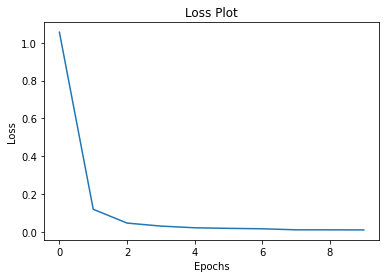

In [23]:
import matplotlib.pyplot as plt

plt.plot(loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()


## Predict Testing Data

In [24]:
ckpt = tf.train.Checkpoint(feature_extractor=feature_extractor,
                           encoder=encoder,
                           decoder=decoder,
                           optimizer=optimizer)
ckpt.restore('./checkpoints/YOLO/ckpt-10')


In [25]:
score = evaluate(dataset_valid)
print(f'Validation accuracy: {score:.2f}')


Validation accuracy: 0.98


In [26]:
def map_test(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = img / 255 * 2 - 1
    return img, img_path

In [27]:
dataset_test = tf.data.Dataset.from_tensor_slices((img_name_test))\
                              .map(map_test, num_parallel_calls=tf.data.experimental.AUTOTUNE)\
                              .batch(100)\
                              .prefetch(tf.data.experimental.AUTOTUNE)


In [28]:
import re

with open('./Lab12-2_110062802.txt', 'w') as fout:
    for step, (img_tensor, img_path) in enumerate(tqdm(dataset_test)):
        pred_list = postprocess(predict(img_tensor).numpy())
        for path, pred in zip(img_path, pred_list):
            path = path.numpy().decode('utf-8')
            name = re.search('(a[0-9]+)', path).group(1)
            fout.write(f'{name} {pred}\n')


100%|██████████| 200/200 [00:28<00:00,  6.92it/s]


## Report

我以YOLOv1 convolution的部分當作feature extractor，其餘encoder、attention與decoder的部分則與助教的相同。由於我的YOLOv1沒有pretrain的weight，因此在update weight的時候還需將YOLOv1的trainable_variables加進去更新。由training的log可以看出在第五個epoch後validation的準確率可以達90%以上，第十個epoch的準確率更可達到98%，因此我取第十個epoch的weight當作我最後的model weight，並用他來預測testing data。

值得一提的是，在training的過程中並不是loss越低validation accuracy越高，可以看到在第六個epoch時明明loss也不錯可是accuracy只有1%，反而相鄰的兩個epoch accuracy都在90%以上，我認為這是因為本次題目是要求predict與target的字要完全相同，而loss無法準確反映在完全相同的字上面，導致loss與accuracy之間有落差，不過這也只是我的推測而已，也有機會是我model的設計有瑕疵導致，真正的原因仍需調查。
